# Evaluation

## Init

In [1]:
# general imports:
import os
import importlib
from torch import nn, cuda
from torch import optim
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

# my imports (reload all modules):

from data.dataset import load_data_deep_crack
from models.unet_resnet34 import UNetResNet34
from models.unet_swin import UNetSwin
from models.unet import UNet
from training.metrics import DiceLoss
from training.metrics import evaluate_dice_index
from training.train import train
from utils import to_4_significant_digits
from utils import count_trainable_parameters
from utils import generate_latex_table_thesis
from plotting import plot_image_mask_prediction_grid


import data.dataset
import models.unet_resnet34
import models.unet_swin
import models.unet
import training.metrics
import training.train
import utils
import plotting

importlib.reload(data.dataset)
importlib.reload(models.unet_resnet34)
importlib.reload(models.unet_swin)
importlib.reload(models.unet)
importlib.reload(training.metrics)
importlib.reload(training.train)
importlib.reload(utils)
importlib.reload(plotting)

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
print(f'Number of visible CUDA devices: {cuda.device_count()}')
cuda.is_available()
# NOTE: when referring to a CUDA device, torch will only know about visible devices
#       so while currently we will be using gpu05
#       this will be device `cuda:0`

# LOAD THE DATA
data_source ='../../DeepCrack/dataset/DeepCrack'
train_image_dir = data_source + '/train_img'
train_mask_dir = data_source + '/train_lab'
test_image_dir = data_source + '/test_img'
test_mask_dir = data_source + '/test_lab'
train_dl, val_dl, train_dataset, val_dataset = load_data_deep_crack(train_image_dir, train_mask_dir, [0.8, 0.2], limit_im_nr=10)
# use validation to avoid augmentation
_, test_dl, _, test_dataset = load_data_deep_crack(test_image_dir, test_mask_dir, [0, 1])

c:\Users\Csaba\miniconda3\envs\cenv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Csaba\miniconda3\envs\cenv2\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Number of visible CUDA devices: 1
This gives us 240 train and 60 validation samples.
This gives us 0 train and 237 validation samples.


c:\Users\Csaba\miniconda3\envs\cenv2\Lib\site-packages\torch\utils\data\dataset.py:473: UserWarning: Length of split at index 0 is 0. This might result in an empty dataset.
  warnings.warn(


## UNET

## UNET all

In [ ]:
import numpy as np
import torch
from tqdm import tqdm

# List of model subdirectories
#path_list = ['resnet_1', 'resnet_unfreeze2_1', 'resnet_unfreeze2_2', 'resnet_unfreeze2_3', 'resnet_unfreeze2_4']
path_list = ['resnet_1', 'resnet_unfreeze_again_1', 'resnet_unfreeze_again_2', 'resnet_unfreeze_again_3', 'resnet_unfreeze_again_4']
learning_rates = [ "1e-3", "1e-4", "1e-5", "1e-5", "1e-5"]
started_from_models = [ "none", "resnet-1", "resnet-1", "resnet-1", "resnet-1"]
names = [ "resnet-1", "resnet-1-1", "resnet-1-2", "resnet-1-3", "resnet-1-4"]
weights = [ "best_model_wts", "model_state_epoch_50", "model_state_epoch_50","model_state_epoch_50","model_state_epoch_50"]
epochs = [200, 100, 100,100,100]
#path_list = ['unet_6']

# Corresponding model parameter sets
experiments = [
    (['non_existing_layer'], "none"),                       # B: Unfreeze layer4
    (['encoder4'], "layer4"),                       # B: Unfreeze layer4
    (['encoder3', 'encoder4'], "layer4, layer3"),           # C: Unfreeze layers 3,4
    (['encoder2', 'encoder3', 'encoder4'], "layer4, layer3, layer2"),# D: Unfreeze layers 2,3,4
    (None, "layer4, layer3, layer2, layer1"),                                # E: Unfreeze all
]
# A list to store all evaluation results for later processing
results = []

# Iterate through all models and evaluate
for idx, (path) in enumerate(path_list, 1):
    print(f"\nProcessing model: {idx}/{len(path_list)} ({path})")
    layers = experiments[idx-1][0]
    layers_text = experiments[idx-1][1]
    # Initialize model and loss function
    model = UNetResNet34(   img_channels = 3,
                mask_channels = 1,
                base_channel_size = 64)  
    loss_fn = DiceLoss()

    # Load model training statistics
    model_dir = f'../saved_models/{path}'
    dice_idcs = list(np.load(f'{model_dir}/dice_idcs.npy'))
    epoch_dice_idcs = list(np.load(f'{model_dir}/epoch_dice_idcs.npy'))
    val_dice_idcs = list(np.load(f'{model_dir}/val_dice_idcs.npy'))
    train_loss = list(np.load(f'{model_dir}/train_loss.npy'))
    val_loss = list(np.load(f'{model_dir}/val_loss.npy'))
    epoch_durations = list(np.load(f'{model_dir}/epoch_durations.npy'))
    model.freeze_encoder_layers()
    model.unfreeze_encoder_layers(layers)
    # Load best weights
    model.load_state_dict(torch.load(f'{model_dir}/{weights[idx-1]}.pth', weights_only=True))
    model.eval().cuda()

    # Evaluate on test set
    avg_score, score_list, preds = evaluate_dice_index(model, test_dataset)

    # Store everything in a dictionary
    result_entry = {
        "name": names[idx-1],
        "dice_idcs": dice_idcs,
        "epoch_dice_idcs": epoch_dice_idcs,
        "val_dice_idcs": val_dice_idcs,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "epoch_durations" :epoch_durations,
        "test_avg_dice": avg_score,
        "test_dice_scores": score_list,
        "test_predictions": preds,
        "layers_unfreze": layers_text,
        "number_of_params": count_trainable_parameters(model),        
        "epoch_nr": epochs[idx-1],
        "lr": learning_rates[idx-1],
        "started_from": started_from_models[idx-1]
    }

    # Append results
    results.append(result_entry)

print("\nAll models processed.")



Processing model: 1/5 (resnet_1)


c:\Users\Csaba\miniconda3\envs\cenv2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Csaba\miniconda3\envs\cenv2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Csaba\miniconda3\envs\cenv2\Lib\site-packages\torch\nn\modules\conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.con


Processing model: 2/5 (resnet_unfreeze_again_1)

Processing model: 3/5 (resnet_unfreeze_again_2)

Processing model: 4/5 (resnet_unfreeze_again_3)

Processing model: 5/5 (resnet_unfreeze_again_4)

All models processed.


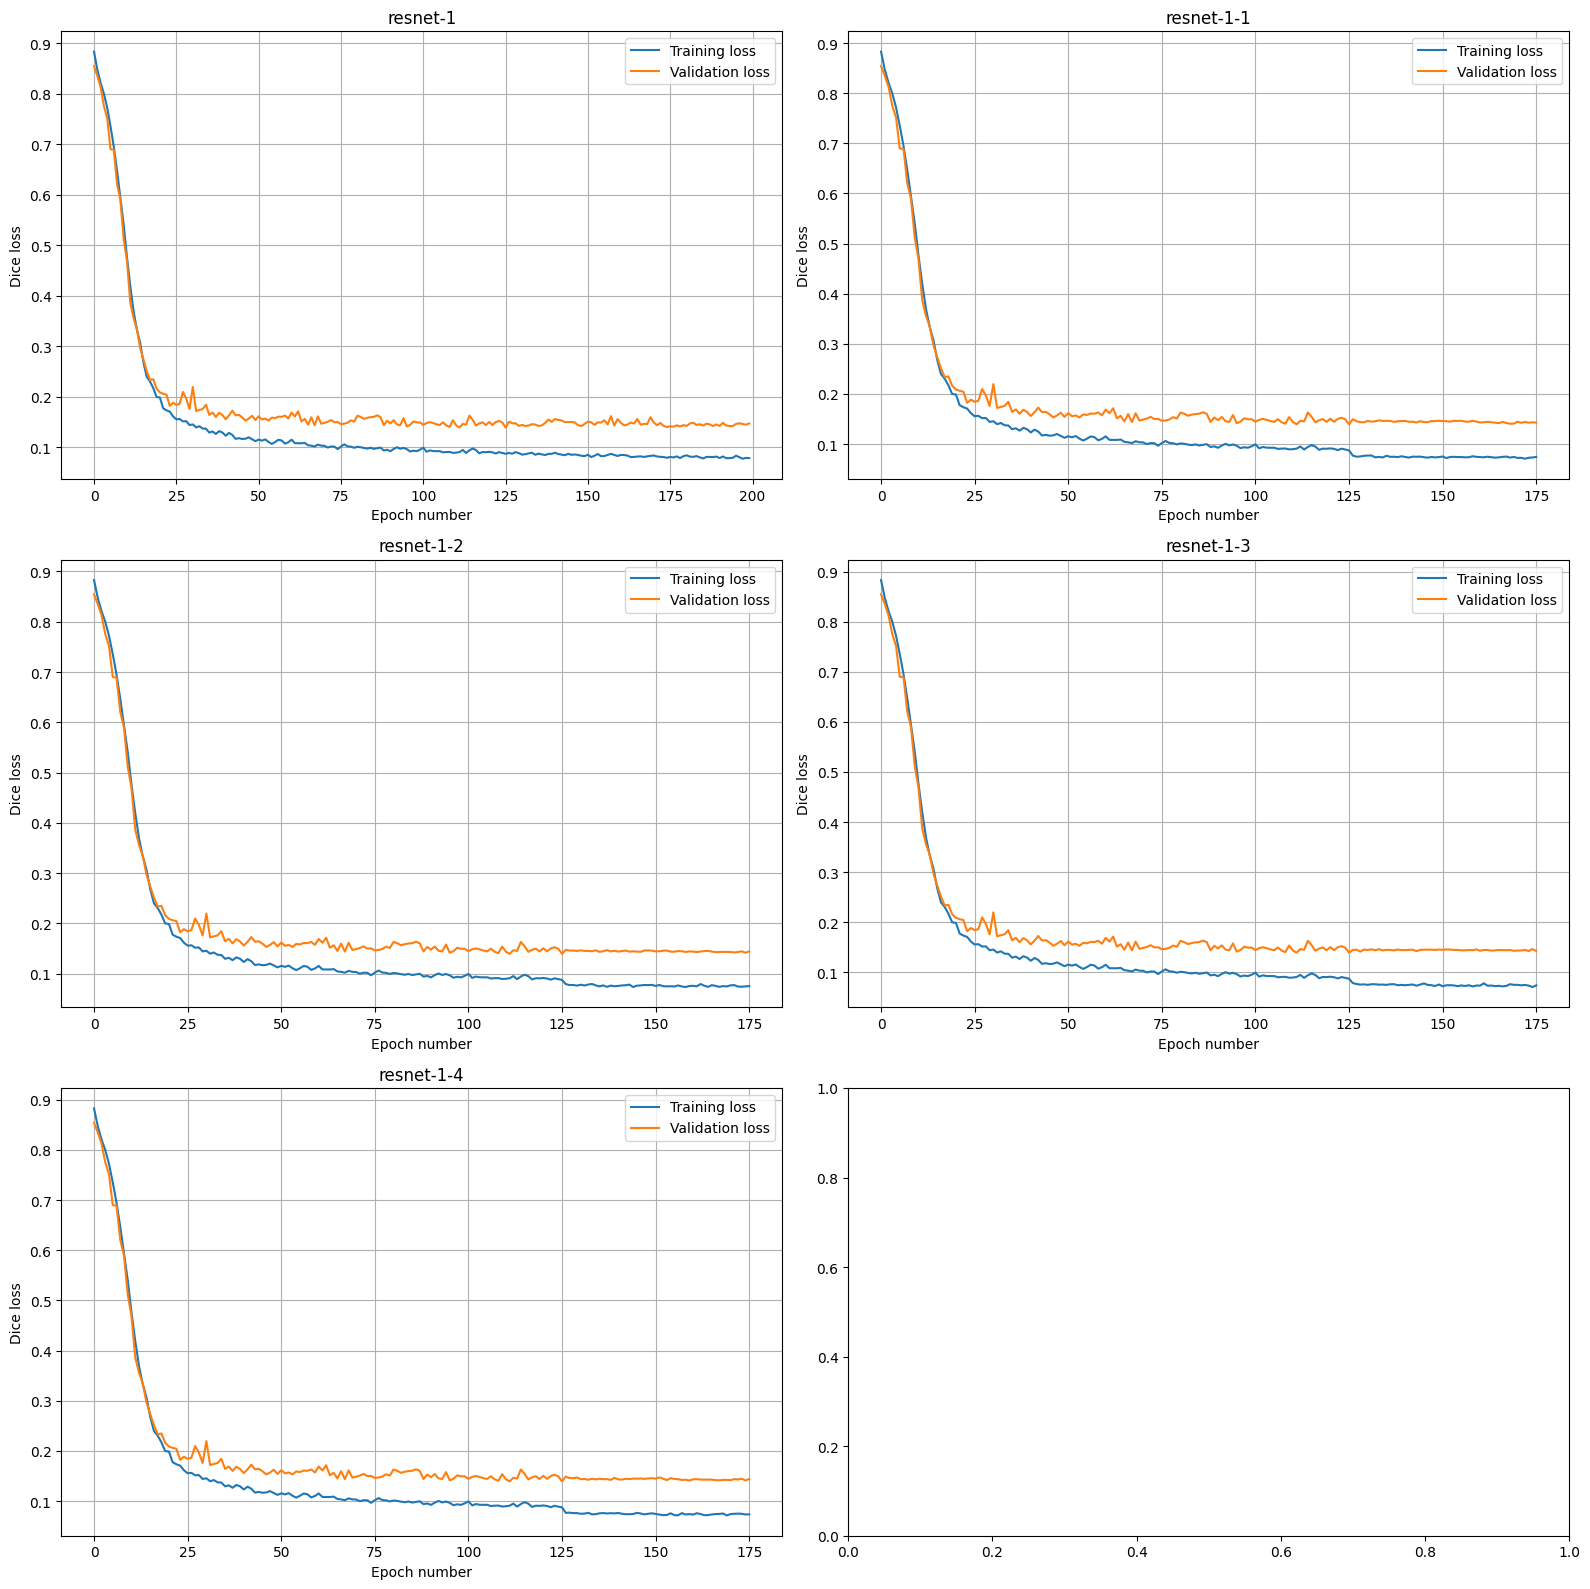

In [3]:
# Set up the subplot grid
fig, axs = plt.subplots(3, 2, figsize=(16, 16))
axs = axs.flatten()  # Flatten the 2D grid into 1D for easier indexing

# Plot each model's loss curves
for i, res in enumerate(results):
    ax = axs[i]
    
    # Plot training and validation loss
    ax.plot(res["train_loss"][:], label='Training loss')
    ax.plot(res["val_loss"][:], label='Validation loss')
    
    ax.set_title(res["name"])
    ax.set_xlabel("Epoch number")
    ax.set_ylabel("Dice loss")
    ax.grid(True)
    ax.legend()


plt.tight_layout()
plt.savefig("../outputs/generated_figures/resnet_losses.png", dpi=300, bbox_inches='tight')
plt.show()

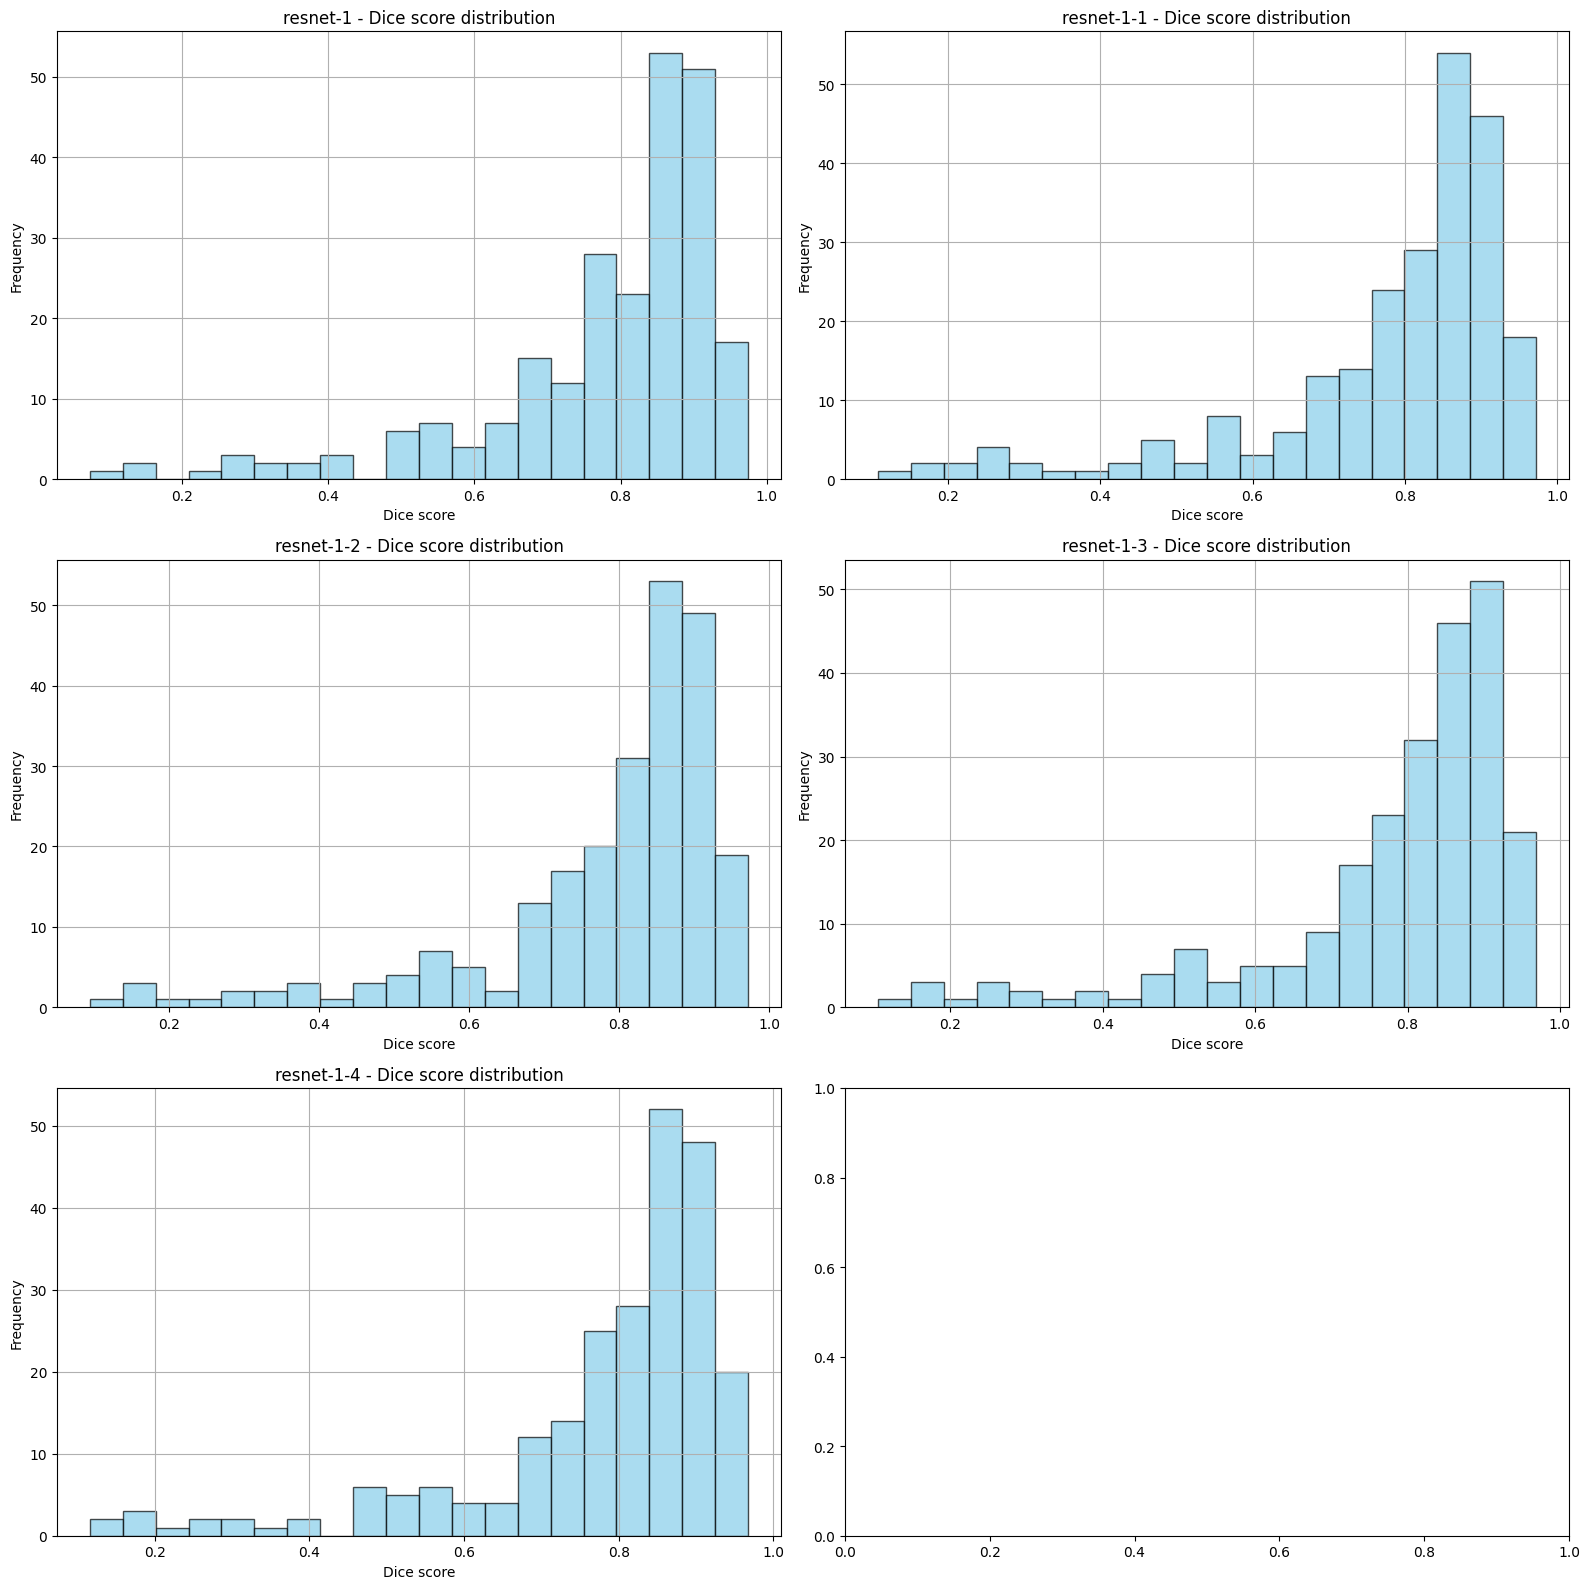

In [4]:
import matplotlib.pyplot as plt

# Set up the 2x2 subplot grid
fig, axs = plt.subplots(3, 2, figsize=(16, 16))
axs = axs.flatten()

# Plot histograms for the first 4 models
for i in range(5):
    res = results[i]
    ax = axs[i]
    
    ax.hist(res['test_dice_scores'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax.set_title(f"{res['name']} - Dice score distribution")
    ax.set_xlabel("Dice score")
    ax.set_ylabel("Frequency")
    ax.grid(True)

plt.tight_layout()
plt.savefig("../outputs/generated_figures/resnet_dice_dist.png", dpi=300, bbox_inches='tight')
#plt.show()


In [10]:
# Build a list of dictionaries with desired summary information
summary_data = []

for res in results:
    summary_data.append({
        "Name": res["name"],
        "Learning rate": res["lr"],  # Adjust if you stored learning rate elsewhere
        "Epochs": res["epoch_nr"],
        "Unfreezed layers": res["layers_unfreze"],
        "Million parameters": to_4_significant_digits(res["number_of_params"]/1000000),
        "Started from": res["started_from"]
    })

# Create DataFrame
summary_df = pd.DataFrame(summary_data)
generate_latex_table_thesis(summary_df, '../outputs/tables/resnet_summary.tex')
# Display the DataFrame
print(summary_df)

         Name Learning rate  Epochs                Unfreezed layers  \
0    resnet-1          1e-3     200                            none   
1  resnet-1-1          1e-4     100                          layer4   
2  resnet-1-2          1e-5     100                  layer4, layer3   
3  resnet-1-3          1e-5     100          layer4, layer3, layer2   
4  resnet-1-4          1e-5     100  layer4, layer3, layer2, layer1   

  Million parameters Started from  
0              7.838         none  
1              20.95     resnet-1  
2              27.77     resnet-1  
3              28.89     resnet-1  
4              29.12     resnet-1  


In [6]:
# Prepare summary data
summary_data = []

for res in results:
    # Compute training time in hours
    total_seconds = sum(res.get("epoch_durations", []))
    training_time_hours = round(total_seconds / 3600, 3)

    # Build the row dictionary
    summary_data.append({
        "Name": res["name"],
        "Average Dice index": round(res["test_avg_dice"], 3),
        "Training time [hours]": training_time_hours
    })

# Create DataFrame
summary_df = pd.DataFrame(summary_data)
generate_latex_table_thesis(summary_df, '../outputs/tables/resnet_results.tex')
# Display the result
print(summary_df)

         Name  Average Dice index  Training time [hours]
0    resnet-1               0.782                  2.335
1  resnet-1-1               0.781                  2.409
2  resnet-1-2               0.784                  2.145
3  resnet-1-3               0.782                  2.181
4  resnet-1-4               0.781                  2.237


In [ ]:
# Sort the scores and keep track of original indices
sorted_pairs = sorted(enumerate(results[0]['test_dice_scores'],), key=lambda x: x[1])

# Extract the sorted scores and their original indices
sorted_scores = [score for idx, score in sorted_pairs]
original_indices = [idx for idx, score in sorted_pairs]
print(sorted_scores)
print(original_indices)


[0.13611412048339844, 0.17661325633525848, 0.24835336208343506, 0.3198156952857971, 0.4563036262989044, 0.47845131158828735, 0.48040029406547546, 0.5000311732292175, 0.5156780481338501, 0.538455069065094, 0.5478761196136475, 0.5507611036300659, 0.5534566044807434, 0.5604351758956909, 0.569556713104248, 0.582392692565918, 0.5826579928398132, 0.5881227254867554, 0.594169557094574, 0.5959203839302063, 0.5992238521575928, 0.6123725175857544, 0.6149192452430725, 0.6162357926368713, 0.621375322341919, 0.6241936087608337, 0.6264699101448059, 0.6438760757446289, 0.6477875113487244, 0.654702365398407, 0.6549326181411743, 0.6552891731262207, 0.6950281262397766, 0.7012108564376831, 0.7085344195365906, 0.7091125249862671, 0.711251974105835, 0.7233343720436096, 0.7260801792144775, 0.7262952327728271, 0.7282600402832031, 0.7291159629821777, 0.7299246191978455, 0.7368574738502502, 0.7406996488571167, 0.7478247880935669, 0.7486329078674316, 0.7514402270317078, 0.7534170746803284, 0.7551483511924744, 0

In [17]:
test_dataset.get_image_name(original_indices[1])

'IMG24-2.jpg'